In [1]:
# resources
# https://www.youtube.com/watch?v=q3DLdMj5zLA
# https://www.youtube.com/watch?v=p_BsFdV_LUk
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons
# https://rasterio.readthedocs.io/en/latest/#rasterio-access-to-geospatial-raster-data

In [2]:
# IMPORTS
import os
import fiona
import rasterio
import geopandas as gpd
from matplotlib import pyplot as plt
from rasterio.features import shapes

In [3]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [4]:
# SETUP
# Ensure these directories exist before running notebook.
IMG_PATH = "../../../resources/segmentation_output_tif/"
OUTPUT_PATH = "../../../resources/output/"

In [5]:
# IMAGE PATHS
def generate_image_paths(path):
    return sorted([f"{path}{name}" for name in os.listdir(path)])

In [6]:
# SHAPEFILE GENERATOR
def generate_shapefiles(paths, output_path):
    if not output_path.endswith('/'):
        output_path = f'{output_path}/'

    with rasterio.Env():
        for idx, path in enumerate(paths):
            with rasterio.open(path) as src:
                image = src.read(1) 
                results = (
                    {'properties': {'raster_val': v}, 'geometry': s}
                    for (s, v)
                    in shapes(image, transform=src.transform) if v > 1
                )

                with fiona.open(
                    f'{output_path}shapefile_{idx}.shp',
                    'w',
                    'ESRI Shapefile',
                    crs=src.crs,  # src.crs is currently None, this needs to figured out.
                    schema={'properties': [('raster_val', 'int')], 'geometry': 'Polygon'}
                ) as dst:
                    dst.writerecords(results)

    print(f'Shapefile(s) written to {output_path}')
    

In [7]:
# RUN
paths = generate_image_paths(IMG_PATH)
generate_shapefiles(paths, OUTPUT_PATH)

Shapefile(s) written to ../../../resources/output/


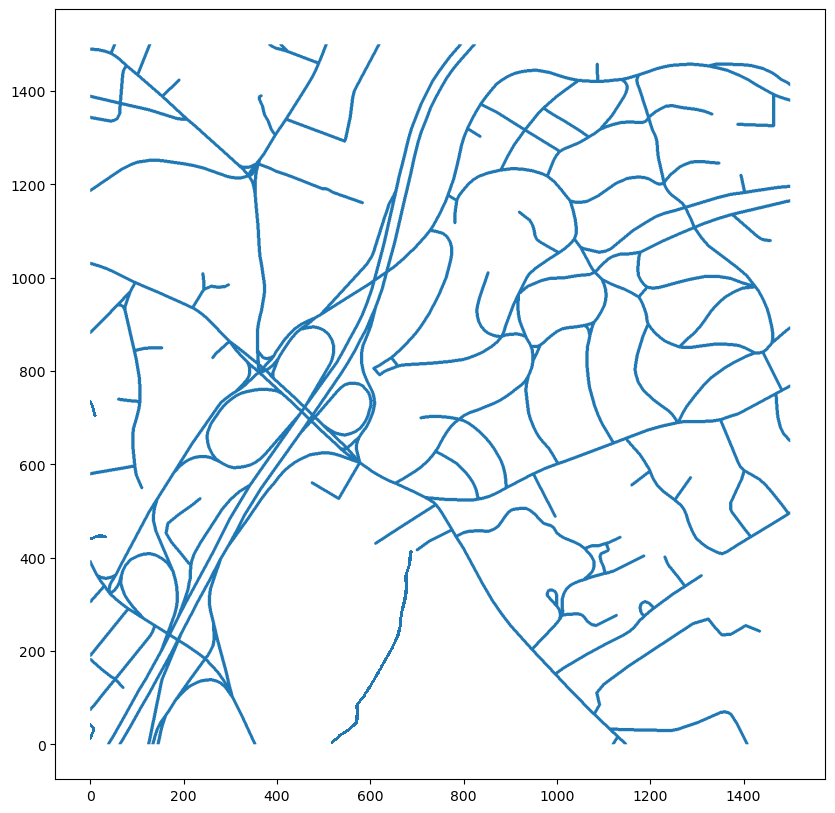

In [8]:
# PLOT
shapefile = gpd.read_file(f'{OUTPUT_PATH}shapefile_0.shp')
fig, ax = plt.subplots(figsize=(10, 10))

shapefile.plot(ax=ax)
plt.show()
